## Оглавление
- <a href='#description'>Задание.</a>
- <a href='#lib'>Загружаем библиотеки используемые в проекте.</a>


- <a href='#load'>Загрузка таблиц. Предобработка данных.</a>
    - <a href='#sales'>Таблица sales.</a> 
    - <a href='#items'>Таблица items.</a>
    - <a href='#stok'>Таблица stock.</a>
    - <a href='#findings_load'>Выводы по предобработке данных.</a>
    
   
- <a href='#eda'>Исследовательский анализ данных.</a>
    - <a href='#data'>Исследуем готовую таблицу data.</a>
    - <a href='#findings_eda'>Выводы из исследовательского анализа.</a>
    
    
- <a href='#time_series'>Анализ временного ряда.</a>  
- <a href='#findings'>Основные выводы перед моделированием.</a>
- <a href='#features'>Подготовка данных для моделирования (feature engineering).</a>
- <a href='#ml'>Моделирование. Выбор алгоритма и метрик.</a>



<a id='description'></a>
## Задание

Цель - необходимо посторить прогноз продаж на месяц (март 2020) года.

Имеются исторические данные за 2 полных года, а также 1 квартал 2020 года. В наборе данных представлены продажи по двум брендам в 3х магазинах. 

<a id='lib'></a>
## Загружаем библиотеки используемые в проекте

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

#библиотеки для ML
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<a id='load'></a>
## Загрузка таблиц. Предобработка данных.

In [2]:
# продажи за 2 полных года 18-20 и первый квартал 21ого + инф-ия о акциях
sales = pd.read_excel('sales_train.xlsx')

# нулевой баланс на складе
stock = pd.read_excel('stock.xlsx')

# информация о позициях и брендах
items = pd.read_csv('items.csv')

# образец того как должен выглядеть итоговый файл 
test_submission = pd.read_csv('test_submission.csv', sep=';')

В первую очередь посмотрим как должен выглядить файл с прогнозом `test_submission `

In [3]:
test_submission.head() 

,ID,date_block_num,shop_id,item_id,item_cnt_month
0,0,26,111,14109600005,NaN
1,1,26,111,15200200023,NaN
2,2,26,111,18057600004,NaN
3,3,26,111,14100300004,NaN
4,4,26,111,32011200075,NaN


In [4]:
test_submission.nunique()

ID                3177
date_block_num       1
shop_id              3
item_id           1059
item_cnt_month       0
dtype: int64

Необходимо представить прогноз по продажам для каждого магазина по позициям на месяц (26й месяц - март 2020 года)

<a id='sales'></a>
###  Таблица `sales` - продажи за период с 2018.01.01 по 2019.02.28

In [5]:
sales.sample(5)

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo
94773,2020-02-29,2,2020,25,115,128,16923312048,10021,1,650,325,1,50,3,0
16440,2018-07-04,7,2018,6,27,128,16925664004,10021,1,314,0,0,0,0,0
53111,2019-04-07,4,2019,15,67,128,16925552008,10021,1,300,0,0,0,0,0
45650,2019-02-19,2,2019,13,61,110,15803088002,10021,1,420,0,0,0,0,0
15553,2018-06-23,6,2018,5,25,111,20220592004,10013,1,182,55,1,30,1,0


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99814 entries, 0 to 99813
Data columns (total 15 columns):
date              99814 non-null datetime64[ns]
Month             99814 non-null int64
Year              99814 non-null int64
date_block_num    99814 non-null int64
week              99814 non-null int64
shop_id           99814 non-null int64
item_id           99814 non-null int64
brand_id          99814 non-null int64
item_cnt_day      99814 non-null int64
item_price        99814 non-null int64
discamount        99814 non-null int64
promo             99814 non-null int64
size_disc         99814 non-null int64
promo_time        99814 non-null int64
spec_promo        99814 non-null int64
dtypes: datetime64[ns](1), int64(14)
memory usage: 11.4 MB


Пропущенных значений нет  
В целом данные соответствуют указанным типам.

Приведем названия столбцов к общему виду

In [7]:
sales.columns = sales.columns.str.lower()

Посмотрим на полные дубликаты 

In [8]:
print('Кол-во дубликатов :', sales.duplicated().sum())
print(sales.duplicated().sum() / len (sales))

Кол-во дубликатов : 8340
0.08355541306830705


у нас 8340 полных дубликатов или 8% от всех данных

Посмотрим на дубликаты, возможно запись идет для каждой позиции, а не суммируется по дням

In [9]:
sales[sales.duplicated(keep=False)].sort_values(by=['item_id','date']).head(5)

,date,month,year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo
61632,2019-06-14,6,2019,17,77,110,7851312001,10013,1,291,146,1,50,3,0
61713,2019-06-14,6,2019,17,77,110,7851312001,10013,1,291,146,1,50,3,0
12571,2018-05-18,5,2018,4,20,128,7851312002,10013,1,460,184,1,40,2,0
12584,2018-05-18,5,2018,4,20,128,7851312002,10013,1,460,184,1,40,2,0
18796,2018-08-04,8,2018,7,31,110,7851312002,10013,1,468,0,0,0,0,0


Предполагаю, что данные по продажам не суммируются по позициям за день - осталяем дуликаты.

<a id='items'></a>
### Таблица `items` - в данной таблице представлена информация по брендам. Код бренда и категории.

In [10]:
items.sample(5)

,item_id,brand_id,item_category_id
731,17027584006,10013,555
180,7851312002,10013,333
640,15799168064,10021,444
906,20220368003,10013,444
131,16924432022,10021,555


In [11]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 3 columns):
item_id             1367 non-null object
brand_id            1367 non-null int64
item_category_id    1367 non-null int64
dtypes: int64(2), object(1)
memory usage: 32.2+ KB


Пропущенных значений нет. `item_id` имеет тип object, а в таблице ***sale***  - int. Эот момент исправим перед исследовательским анализом.

In [12]:
items.nunique()

item_id             1367
brand_id               2
item_category_id       4
dtype: int64

In [13]:
items.duplicated().sum()

0

In [14]:
items.groupby(['brand_id','item_category_id'])['item_id'].nunique()

brand_id  item_category_id
10013     333                  57
          444                 499
          555                 149
10021     333                   7
          444                 428
          555                 223
          666                   4
Name: item_id, dtype: int64

Всего 2 бренда и 4 категории - для каждой из категорий по уникальному id

<a id='stok'></a>
### Таблица `stock`

В таблице stock - для каждого товара и магазина указано количество дней на складе с нулевым остатком - сколько дней товара не было на складе.

In [15]:
stock.sample(5)

,store,month,days with 0 balance,year,itemid
15604,111,11,10,2019,15819104008
7586,128,11,1,2019,15818880025
3311,110,11,15,2018,90036912012
1543,110,11,1,2018,15793904009
5940,128,9,1,2018,15799168039


In [16]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17678 entries, 0 to 17677
Data columns (total 5 columns):
store                  17678 non-null int64
month                  17678 non-null int64
days with 0 balance    17678 non-null int64
year                   17678 non-null int64
itemid                 17678 non-null int64
dtypes: int64(5)
memory usage: 690.7 KB


Пропущенных значений в таблице нет. `itemid` - тоже тип int, как и в ***sales***.
Немного приведем в порядок названия столбцов.

In [17]:
stock = stock.rename(columns={"store":"shop_id",
                              "days with 0 balance":"days_with_0_balance",
                              "itemid":"item_id"})

Проверим наличие дубликатов

In [18]:
print(stock.duplicated().sum())
print(stock.duplicated().sum() / len(stock))

1188
0.06720217219142437


In [19]:
stock[stock.duplicated(keep=False)].sort_values(by=['item_id','year','month','shop_id']).head(10)

,shop_id,month,days_with_0_balance,year,item_id
9093,110,10,22,2019,15792112003
13968,110,10,22,2019,15792112003
75,111,7,3,2018,15792336004
6077,111,7,3,2018,15792336004
217,111,8,4,2018,15792336004
5855,111,8,4,2018,15792336004
12857,110,3,11,2019,15792336004
15457,110,3,11,2019,15792336004
7430,110,10,6,2019,15792560016
14051,110,10,6,2019,15792560016


Происхождение дубликатов непонятно. В целом - такой момент конечно нужно уточнить. Сейчас предположу, что вызванно это ошибкой и удалю такие дубликаты.

Перед удалением, проверим предположение - для каждой позиции время отсутствия на складе не суммируется, например,  позиции нет на складе - запись, потом позиция появляется в наличии, затем снова отсутствует - новая запись. Для проверки просуммируем для каждой позиции, время ее отсутствия на складе - время не должно превышать 31 день (или длины соответствующего месяца).

In [20]:
(stock.groupby(['year','month','shop_id','item_id'])['days_with_0_balance']
    .sum()
    .reset_index()
    .sort_values('days_with_0_balance', ascending=False))

,year,month,shop_id,item_id,days_with_0_balance
8521,2019,5,111,16924544025,60
2577,2018,8,110,16924992013,60
7257,2019,3,128,16925664004,60
8590,2019,5,128,16925664006,60
14522,2020,3,111,35865312115,60
...,...,...,...,...,...
9219,2019,6,111,16923312059,1
9218,2019,6,111,16923312057,1
9217,2019,6,111,16923312056,1
9216,2019,6,111,16923312054,1


Да, есть позиции со сроком 60 дней. Предполагаю, что для дальнейшего анализа и построения прогноза даннные дубликаты можно удалить.

In [21]:
stock = stock.drop_duplicates().reset_index(drop=True)

In [22]:
len(stock)

16490

In [23]:
#stock.groupby(['year','month'])['item_id'].nunique()

<a id='findings_load'></a>
### Вывод по предобработке данных  
Пропущенных значений в таблицах не обнаружено. Есть дубликаты в sales - объясняю это тем, что данные о продажах не суммируются за день. Дубликаты в stock - удалены. item_id - в разных таблицах отличается тип (int/object) - это обработаем во время исследовательского анализа.  
**p.s. происхождение дубликатов конечно нужно уточнить!**

<a id='eda'></a>
__________
## Исследовательский анализ данных

В целом в исследовательском анализе будем отталкиваться от поставленной задачи - прогноз продаж на месяц в шт.

Объединим таблицы ***sales*** и ***items*** в общую таблицу ***data*** по `item_id`. Сначала преобразуем тип `item_id` в ***sales*** - в str

In [24]:
sales['item_id'] = sales['item_id'].astype('str')

In [25]:
print('items - уникальных id',items['item_id'].nunique())
print('sales - уникальных id',sales['item_id'].nunique())

items - уникальных id 1367
sales - уникальных id 1399


Ункальных `item_id` в ***sales*** больше чем в ***items*** - посмотрим на эти позиции.

In [26]:
items_id_list = items['item_id'].unique()
sales.query('item_id not in @items_id_list')['item_id'].nunique()

33

У нас нет полных данных о бренде и категории товара для 33 позиций. 406 строк из sales. Считаю, что их можно убрать из общего анализа. 

В ***items*** обнаружен id - #Н/Д

In [27]:
items['item_id'].sort_values()

535           #Н/Д
500    15792112003
875    15792224009
580    15792336004
346    15792336006
          ...     
754    90036912004
479    90036912007
226    90036912012
55     90036912013
152    90037584002
Name: item_id, Length: 1367, dtype: object

In [28]:
#sales['item_id'].sort_values()

In [29]:
items[items['item_id'] == "#Н/Д"]

,item_id,brand_id,item_category_id
535,#Н/Д,10013,444


Так как в ***sales*** id "#Н/Д" нет - этот товар у нас не попадет в итоговую таблицу при объединении.

Объединяем 2 таблицы - ***items*** и ***stock***. 

In [30]:
data = sales.merge(items, on=['item_id','brand_id'], how="left")

In [31]:
len(data)

99814

In [32]:
data = data.dropna().reset_index(drop=True)
len(data)

99408

<a id='data'></a>
### Исследуем готовую таблицу data

In [33]:
data.head()

,date,month,year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0,444.0
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0,444.0
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0,333.0
3,2018-01-01,1,2018,0,1,111,20221376004,10013,1,139,0,0,0,0,0,444.0
4,2018-01-01,1,2018,0,1,111,20221040001,10013,1,135,0,0,0,0,0,444.0


In [34]:
data.query('date_block_num != 26').describe()

,month,year,date_block_num,week,shop_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id
count,94779.000000,94779.000000,94779.000000,94779.000000,94779.000000,94779.00000,94779.000000,94779.000000,94779.000000,94779.000000,94779.000000,94779.000000,94779.000000,94779.000000
mean,6.485656,2018.658585,13.388673,61.429241,115.696853,10017.72113,1.109170,405.539297,87.775013,0.437185,19.744247,4.966290,0.070121,490.605735
std,3.708639,0.613125,7.139490,31.634357,7.963489,3.93448,0.488806,258.135641,130.913761,0.496041,22.705936,9.258732,0.255352,64.048897
min,1.000000,2018.000000,0.000000,1.000000,110.000000,10013.00000,-4.000000,0.000000,-723.000000,0.000000,0.000000,0.000000,0.000000,333.000000
25%,3.000000,2018.000000,8.000000,37.000000,110.000000,10013.00000,1.000000,254.000000,0.000000,0.000000,0.000000,0.000000,0.000000,444.000000
50%,6.000000,2019.000000,14.000000,62.000000,111.000000,10021.00000,1.000000,335.000000,0.000000,0.000000,0.000000,0.000000,0.000000,444.000000
75%,10.000000,2019.000000,20.000000,89.000000,128.000000,10021.00000,1.000000,491.000000,150.000000,1.000000,40.000000,4.000000,0.000000,555.000000
max,12.000000,2020.000000,25.000000,115.000000,128.000000,10021.00000,22.000000,3681.000000,1841.000000,1.000000,50.000000,29.000000,1.000000,666.000000


что можно заметить из особенностей:  
- `item_cnt_day` - имеет отрицательны и положительные значения. Среднее и медиана = 1 (еще один аргуемнт в пользу того, что записи не суммируются по дням и позициям). Есть существенные выбросы - мак значение - 22 (хотя медиана и 75й перцентиль - 1) .
- `item_price` - средняя цена 335 руб.(медиана), однако есть и гораздо более дорогие позиции - 3681 руб
- `discamount` - скидка имеет так же отрицательные и положительные значения
- `promo` - метка у 44% процентов записей!

Отдельно посмотрим на каждый из столбцов

In [35]:
data.columns

Index(['date', 'month', 'year', 'date_block_num', 'week', 'shop_id', 'item_id',
       'brand_id', 'item_cnt_day', 'item_price', 'discamount', 'promo',
       'size_disc', 'promo_time', 'spec_promo', 'item_category_id'],
      dtype='object')

count                   99408
unique                    820
top       2018-07-27 00:00:00
freq                      502
first     2018-01-01 00:00:00
last      2020-03-31 00:00:00
Name: date, dtype: object


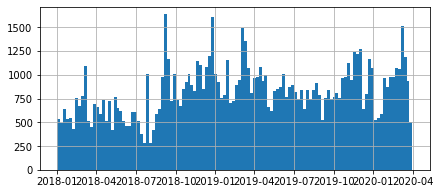

In [36]:
print (data['date'].describe())
data['date'].hist(figsize=(7,3), bins=120)
plt.show()

Данные соответствуют изначальным условиям - два года - 2018,2019 и первый квартал 2020. Явных разрывов не обнаружено.

Помотрим на уникальные значения столбцов - нет ли в них неявных дубликатов.

In [37]:
for i in ['month', 'year', 'date_block_num', 'week', 'shop_id', 'brand_id','promo',
         'size_disc', 'spec_promo','item_category_id']:
    print ('Униакльные значения для ', i)
    print (data[i].unique())
    print ()

Униакльные значения для  month
[ 1  2  3  4  5  6  7  8  9 10 11 12]

Униакльные значения для  year
[2018 2019 2020]

Униакльные значения для  date_block_num
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]

Униакльные значения для  week
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120]

Униакльные значения для  shop_id
[111 128 110]

Униакльные значения для  brand_id
[10013 10021]

Униакльные значения для  promo
[0 1]

Униакльные значения для  size_disc
[ 0 40 35 30 50 45]

Униакльные значения для  spec_promo
[0 1]

Униа

Все в целом соответствует даным - неявных дубликатов не выялено.  
Скидки по promo - 40, 35, 30, 50, 45 %. 

С помощью графиков проанализируем оставшиеся столбцы: 
- 'item_id', 
- 'item_cnt_day',
- 'item_price',
- 'discamount',
- 'promo_time'

Так как от нас требуется прогноз продаж на месяц - проанализируем эти столбцы исходя из суммарных продаж каждой позции в месяц. Для удобства отображеня на графиках выделим месяц от даты. 

In [38]:
data['date_month'] = data['date'].astype('datetime64[M]')

Построим график - на котором сгруппируем продажи каждой позиции по месяцам и магазинам и посмотрим на распределения.

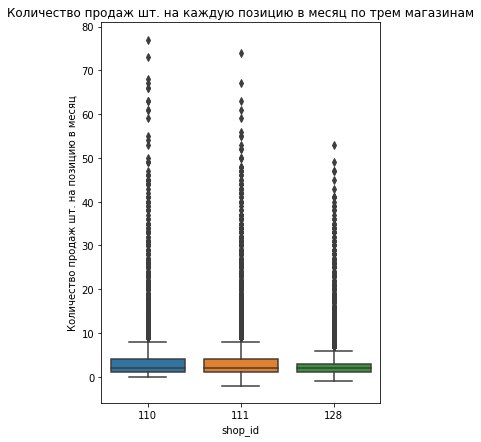

In [39]:
plt.figure(figsize=(5,7))
monthly_sales_per_item = data.query('date_block_num != 26').groupby(['date_block_num',
                                                   'shop_id',
                                                   'item_id'])['item_cnt_day'].sum().reset_index()
sns.boxplot(
data = monthly_sales_per_item,
y = 'item_cnt_day',
x = 'shop_id')
plt.ylabel('Количество продаж шт. на позицию в месяц')
plt.title('Количество продаж шт. на каждую позицию в месяц по трем магазинам')
plt.show()

Для каждого из магазинов продажи одной позиции в среднем в месяц составляют 2-3 шт, но в тоже время есть позиции, которые продаются гораздо лучше. Очень плотный хвост у boxlot для все трех магазинов. У нас есть очень много выбросов - большая разница в продажах позиций - какие то продавались раз в месяц, какие то и больше 70 раз в месяц.

In [40]:
monthly_sales_per_item.groupby('shop_id').agg({'item_cnt_day':['mean','median','max','min']})

item_cnt_day               
                mean median max min
shop_id                            
110         3.469090      2  77   0
111         3.738551      2  74  -2
128         3.093855      2  53  -1

In [41]:
data.query('item_cnt_day < 0').groupby('shop_id')['item_id'].count()

shop_id
110     70
111    106
128     49
Name: item_id, dtype: int64

Отрицательные продажи есть во всех магазинах. 

Посмотрим как распределены цены на товары, сравним максимальные цены для каждого товара.

count    1366.000000
mean      457.347731
std       397.297469
min        34.000000
25%       252.000000
50%       331.000000
75%       504.000000
max      3681.000000
Name: item_price, dtype: float64


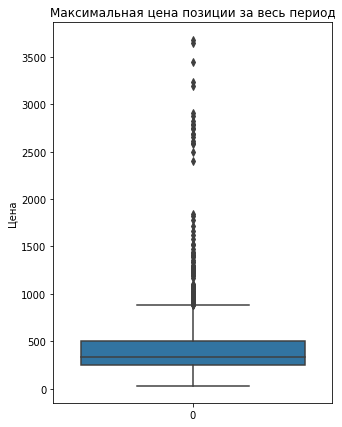

In [42]:
plt.figure(figsize=(5,7))
sns.boxplot(data=data.query('date_block_num != 26').groupby('item_id')['item_price'].max())
plt.ylabel('Цена')
plt.title('Максимальная цена позиции за весь период')
print(data.groupby('item_id')['item_price'].max().describe())

Средняя цена на продукцию - 400 руб. Но ест и сильные выбросы - цены выше 2000р

In [46]:
data.head()

,date,month,year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id,date_month
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0,444.0,2018-01-01
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0,444.0,2018-01-01
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0,333.0,2018-01-01
3,2018-01-01,1,2018,0,1,111,20221376004,10013,1,139,0,0,0,0,0,444.0,2018-01-01
4,2018-01-01,1,2018,0,1,111,20221040001,10013,1,135,0,0,0,0,0,444.0,2018-01-01


In [47]:
(data.query('item_price > 2000').groupby(['item_id'])
                .agg({'item_price':'max','item_category_id':'max'})
                    .reset_index().groupby('item_category_id').count())

,item_id,item_price
item_category_id,,
333.0,1,1
555.0,19,19


В основном это позиции из категории 555

Для `discamount` посчитаем процент скидки - percent_disc

In [48]:
data['percent_disc'] = round((data['discamount'] / data['item_price']) * 100, 0)

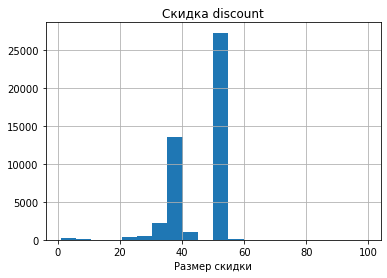

count    45424.000000
mean        45.474617
std          6.747386
min          1.000000
25%         40.000000
50%         50.000000
75%         50.000000
max         99.000000
Name: percent_disc, dtype: float64


In [49]:
data.query("percent_disc > 0")['percent_disc'].hist(bins=20)
plt.title('Скидка discount')
plt.xlabel('Размер скидки')
plt.show()
print (data.query("percent_disc > 0")['percent_disc'].describe())

Средняя скидка на продукцию 40-50%

Посмотрим на время действия акции по `promo_time`

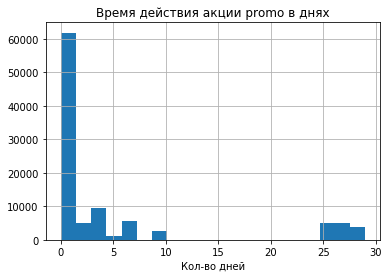

In [50]:
data['promo_time'].hist(bins=20)
plt.title('Время действия акции promo в днях')
plt.xlabel('Кол-во дней')
plt.show()

Акции проходят в срок до 10 дней или 25-30 дней.

Дополнительно посмотрим какие категории товаров продает каждый бренд 

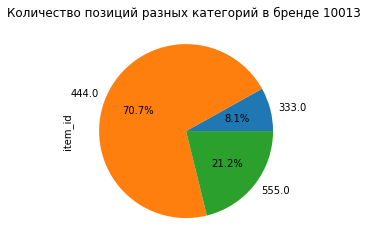

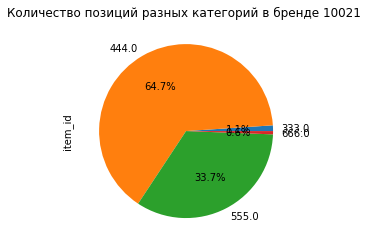

In [51]:
for i in data['brand_id'].unique():
    data.query('brand_id == @i').groupby(['item_category_id'])['item_id'].nunique().plot(kind="pie",autopct='%1.1f%%')
    plt.title('Количество позиций разных категорий в бренде {} '.format(i))
    plt.show()

Оба бренда в основном продают только позиции из категорий 444 и 555. 

<a id='findings_eda'></a>
### Выводы из исследовательского анализа данных

- `item_cnt_day` и `discamount` могут принимать отрицательные значения. Происхождение таких выбросов нужно уточнять.
- Продажи позиций очень неравномерны при группировке по месяцам - для всех трех магазинов, продажи на одну позицию могут иметь очень большой разброс (медианное значение 2, а максимальные значения 50-70 продаж в месяц (шт) на позицию)
- Цена товаров 250 - 500 р. Есть и более дорогие позиции до 3681р - в основном из категории 555.
- Большая часть ассортимета двух брендов это продукты категорий 444 и 555

<a id='time_series'></a>
## Анализ временного ряда

Посмотрим на общее количестово товаров, которые продают магазины

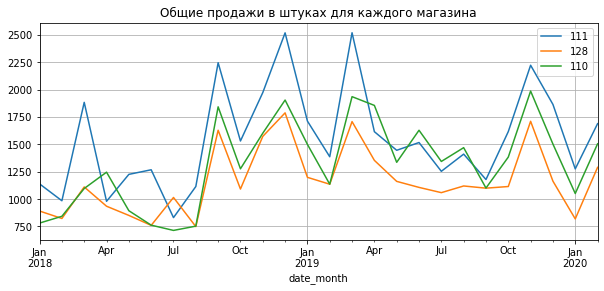

In [52]:
for i in data['shop_id'].unique():
    (data.query('shop_id == @i and date_block_num != 26')
    .groupby('date_month')['item_cnt_day']
    .sum()
    .plot(figsize=(10,4), legend=True, label=i, grid = True))
plt.title('Общие продажи в штуках для каждого магазина')
plt.show()

Сезонность во всех трех магазинах примерно одинаковая - пики продаж - март-апрель и ноябрь-декабрь. Летом происходит небольшой спад.

Посмотрим сколько продается из каждой категории товаров

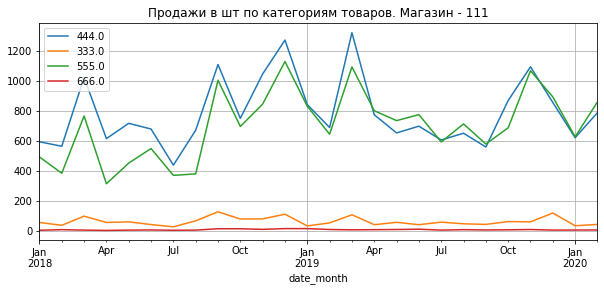

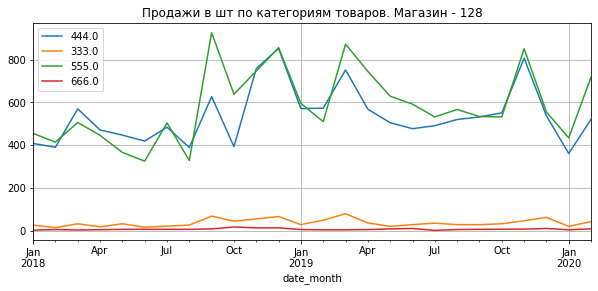

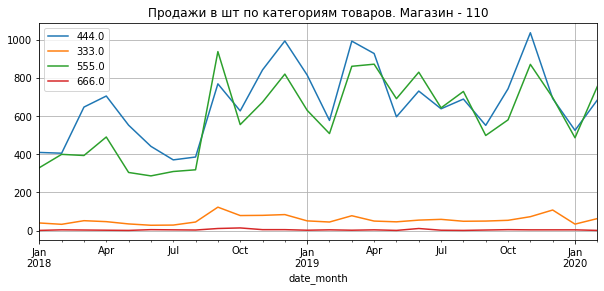

In [53]:
for shop in data['shop_id'].unique():
    fig, ax = plt.subplots()
    for i in data['item_category_id'].unique():
        (data.query('date_block_num != 26 and shop_id == @shop and item_category_id == @i ')
        .groupby('date_month')['item_cnt_day']
        .sum()
        .plot(figsize=(10,4), legend=True, label=i, grid = True,ax=ax))
        plt.title('Продажи в шт по категориям товаров. Магазин - {}'.format(shop))
    plt.show()

Продажи каждой категории товаров также имеют общую сезонность - пики продаж - март-апрель и ноябрь-декабрь.

Продажи по двум брендам

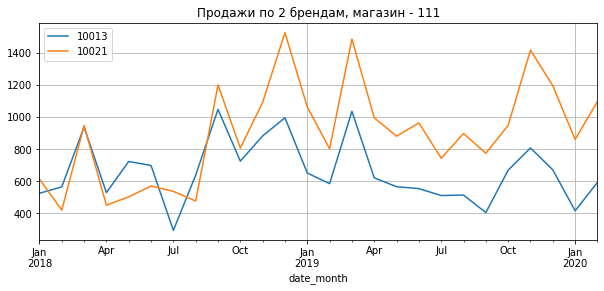

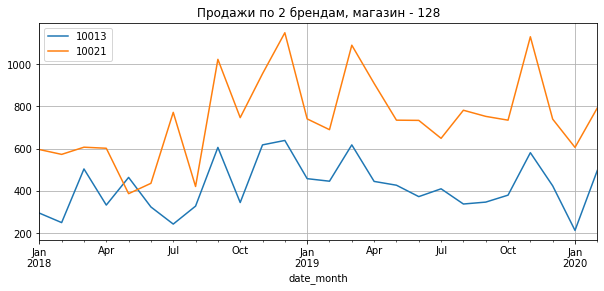

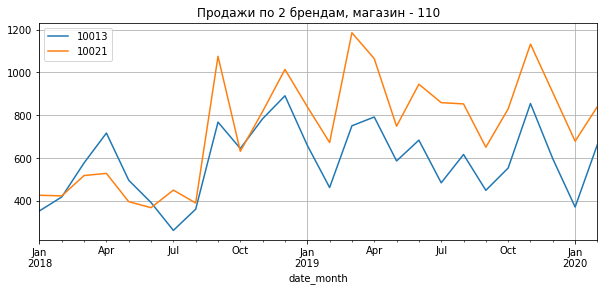

In [54]:
#продажи по 2 брендам
for shop in data['shop_id'].unique():
    fig, ax = plt.subplots()
    for i in data['brand_id'].unique():
        (data.query('date_block_num != 26 and shop_id == @shop and brand_id == @i ')
        .groupby('date_month')['item_cnt_day']
        .sum()
        .plot(figsize=(10,4), legend=True, label=i, grid = True,ax=ax))
        
        plt.title('Продажи по 2 брендам, магазин - {}'.format(shop))
    plt.show()

По графикам можно сказать, что в целом продажи бренда 10021 были выше продаж бренда 10013 - во всех трех магазинах. 

Так как отметка о действии акции на товар (`promo`) есть у 44% записей - посмотрим какая доля товаров продается по акции.

In [55]:
def sales_plot(title, dev):
    (data.groupby(['date_month','item_id'])[dev].max().reset_index()
                .groupby(['date_month'])[dev].mean().plot(figsize=(7,3), grid=True))
    plt.title(title)
    return plt.show()


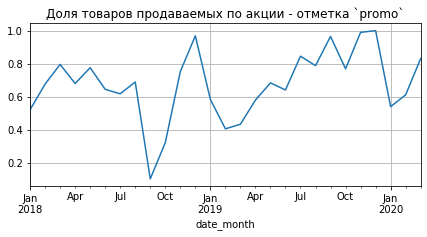

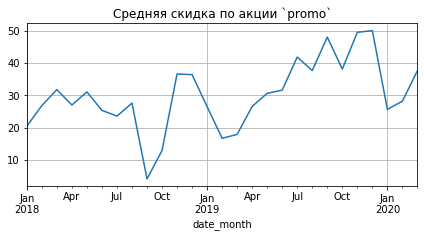

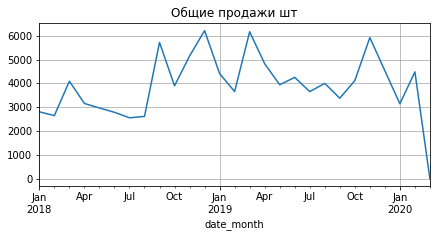

In [56]:
sales_plot('Доля товаров продаваемых по акции - отметка `promo`', 'promo')
sales_plot('Средняя скидка по акции `promo`', 'size_disc')

data.groupby('date_month')['item_cnt_day'].sum().plot(figsize=(7,3), grid=True, 
                                                     title = 'Общие продажи шт')
plt.show()

В декабре 2019 года - 100% товаров продавалось по акции. Интересно заметить, что не смотря на рост скидок и количество товаров учавствующих в акциях, можно заметить спад в продажах летом 2019г. Возможно акций и скидок слишком много и клиенты уже не так сильно реагируют на такой маркетинг.

Так как прогноз нам нужен в штуках на месяц агрегируем данных в продажах по месяцам 

In [57]:
df = (data.groupby(['date_block_num','shop_id','item_id']).agg({
            'month':'max', 
            'year':'max',
            
            'brand_id':'max',
            'item_cnt_day':'sum',
            'item_price':'max',
            'promo':'mean',
            'size_disc':'mean',
            'promo_time':'max',
            'spec_promo':'max',
            'item_category_id':'max',
            'percent_disc':'max'})).reset_index()

Посмотрим на матрицу корреляции 

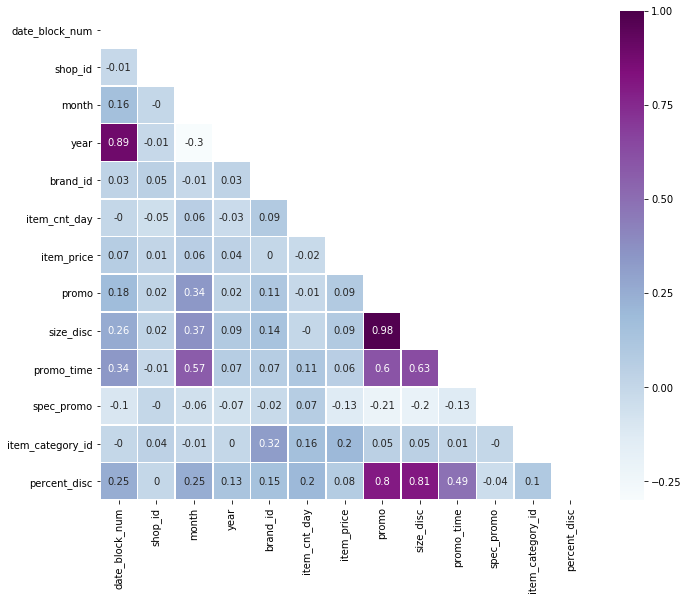

In [58]:
corr_all = df.corr().round(2)
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu", annot=True)      
plt.show()


<a id='findings'></a>
## Основные выводы перед моделированием.

1. Необходимо выяснить происхождение 
    - дубликатов в таблицах ***sales*** и ***stock***.
    - отрицательные значения в столбцах - `item_cnt_day` и `discamount` в таблице ***sales***
2.  Метка `promo` о наличии акции у данной позиции - 44% процентов записей!   
3.  Если оценивать продажи позиций (item_id) по месяцам, то у нас очень большой разброс со средним 2-3 шт на позицию и плотным "хвостом" до 50-70 позиции.
4. Сезонность во всех трех магазинах примерно одинаковая - пики продаж - март-апрель и ноябрь-декабрь. Летом происходит небольшой спад.
5. Анализируемые бренды в основном состоят из продукции категорий 444 и 555
6. Не смотря на рост скидок и количество товаров учавствующих в акциях, можно заметить спад в продажах летом 2019г. 

<a id='features'></a>
## Подготовка данных для моделирования (feature engineering) 

В итоговую таблицу ***df*** добавим средние значения продаж для каждого месяца, магазина и категории товара.

In [59]:
mean_month_sales = (df.query('date_block_num != 26')
                        .groupby(['year','month','shop_id','item_category_id'])['item_cnt_day']
                            .sum().reset_index())

In [60]:
mean_month_sales = (mean_month_sales
                        .groupby(['month','shop_id','item_category_id'])['item_cnt_day']
                            .mean().reset_index())

In [61]:
mean_month_sales = mean_month_sales.rename(columns={"item_cnt_day":"month_shop_cat_mean"})

In [62]:
mean_month_sales.head()

,month,shop_id,item_category_id,month_shop_cat_mean
0,1,110,333.0,41.666667
1,1,110,444.0,584.000000
2,1,110,555.0,482.666667
3,1,110,666.0,2.333333
4,1,111,333.0,39.000000


In [63]:
df = df.merge(mean_month_sales, on=['month','shop_id','item_category_id'], how='left')

В общую таблицу ***df*** добавим информацию о наличии товара на складе из таблицы ***stock***

In [64]:
stock['item_id'] = stock['item_id'].astype('str')

In [65]:
df = df.merge(stock, on=['shop_id','month','year','item_id'], how='left')

In [66]:
df['days_with_0_balance'] = df['days_with_0_balance'].fillna(0)

Добавим лаг по количеству продаж в шт по месяцу для каждой категории 

In [67]:
lag_cat_month = (data.groupby(['item_category_id','date_block_num'])['item_cnt_day']
            .sum().reset_index()
                .sort_values(['item_category_id','date_block_num']))

lag_cat_month['lag'] = lag_cat_month['item_cnt_day'].shift(periods=1) #сдвигаем на 1 месяц
lag_cat_month.loc[lag_cat_month['date_block_num'] == 0, 'lag'] = 0 #нулевой месяц для каждой категории обнулим

lag_cat_month = lag_cat_month.drop(['item_cnt_day'], axis=1)

In [68]:
df = df.merge(lag_cat_month, on=['item_category_id','date_block_num'], how='left')

Теперь обработаем категориальные данные one-hot encoding
- shop_id
- brand_id
- item_category_id 

In [69]:
#в эту таблицу занесем спрогнозируеммые значения она понадобится для подготовки файла с прогнозом
final_submission = df.copy()

In [70]:
for i  in ['shop_id','brand_id','item_category_id']:    
    dum = pd.get_dummies(df[i])
    df = pd.concat([df,dum],axis=1)
    df = df.drop([i], axis=1)

Готовые данные для обучения

In [71]:
df.head()

,date_block_num,item_id,month,year,item_cnt_day,item_price,promo,size_disc,promo_time,spec_promo,percent_disc,month_shop_cat_mean,days_with_0_balance,lag,110,111,128,10013,10021,333.0,444.0,555.0,666.0
0,0,15792560015,1,2018,1,303,0.0,0.0,0,0,0.0,584.0,0.0,0.0,1,0,0,0,1,0,1,0,0
1,0,15792560016,1,2018,1,303,0.0,0.0,0,0,0.0,584.0,0.0,0.0,1,0,0,0,1,0,1,0,0
2,0,15792560017,1,2018,1,303,0.0,0.0,0,0,0.0,584.0,0.0,0.0,1,0,0,0,1,0,1,0,0
3,0,15793344029,1,2018,2,231,0.0,0.0,0,0,0.0,584.0,18.0,0.0,1,0,0,0,1,0,1,0,0
4,0,15793344035,1,2018,2,231,0.5,20.0,1,0,40.0,584.0,1.0,0.0,1,0,0,0,1,0,1,0,0


<a id='ml'></a>
## Моделирование. Выбор алгоритма и метрик.

Для решения поставленной задачи буду пользоваться XGBRegressor(). В данных много выбросов и линеные модели справятся хуже (это дополнительно было проверено). По этой же причине для оценки качества модели и настройки гипермараметров выберем MSE - так как она чувствительна к выбросам. 

Часть данных на которых будем обучать модель. 26 месяц - март 2020 года убираем из выборки - это те данные, которые в итоге нужно смоделировать.

In [72]:
df_work = df.query('date_block_num != 26').copy()
#df_work = df.copy()

Разделим выборку на train и test

In [73]:
#месяц по которому будем делить
month_sep = 23

In [74]:
X_train = df_work.query('date_block_num < @month_sep').drop(['item_id','item_cnt_day'], axis=1)
X_test = df_work.query('date_block_num >= @month_sep').drop(['item_id','item_cnt_day'], axis=1)
y_train = df_work.query('date_block_num < @month_sep')['item_cnt_day']
y_test = df_work.query('date_block_num >= @month_sep')['item_cnt_day']

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)
print ('Процентное разделение', round(len(y_test)/len(y_train)*100),'на', 100-round(len(y_test)/len(y_train)*100) )

(28507, 21)
(3652, 21)
(28507,)
(3652,)
Процентное разделение 13 на 87


In [75]:
# for i  in [.2, .3, .4]:
#     print(i)
#     model = XGBRegressor(n_estimators=100, max_depth=7, lerning_rate=i)
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     print('MSE: {:.2f}'.format(mean_squared_error(y_test, predictions)))
#     print('R2: {:.2f}'.format(r2_score(y_test, predictions)))
#     print('_________________________________________________')
#     print()

Оптимальными для модели были выбраны следующие гиперпараметры - 

In [76]:
model = XGBRegressor(n_estimators=100, max_depth=7, lerning_rate=0.1)

In [77]:
model.fit(X_train, y_train)

[15:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, lerning_rate=0.1,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [78]:
predictions = model.predict(X_test)

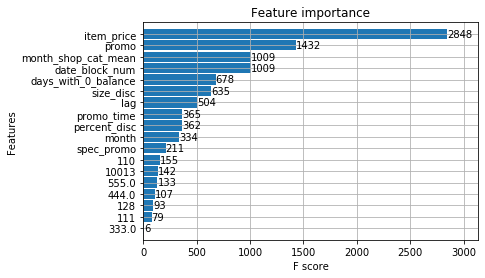

In [79]:
xgb.plot_importance(model, height=0.9)
plt.show()

In [80]:
predictions

array([1.9934036, 4.8236747, 4.6580787, ..., 5.123657 , 1.2111558,
       2.3546138], dtype=float32)

In [81]:
print('Mean: {:.2f}'.format(y_test.mean()))
print('MAE: {:.2f}'.format(mean_absolute_error(y_test, predictions)))
print('MSE: {:.2f}'.format(mean_squared_error(y_test, predictions)))
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, predictions))))
print('R2: {:.2f}'.format(r2_score(y_test, predictions)))

Mean: 3.49
MAE: 2.04
MSE: 16.19
RMSE: 4.02
R2: 0.37


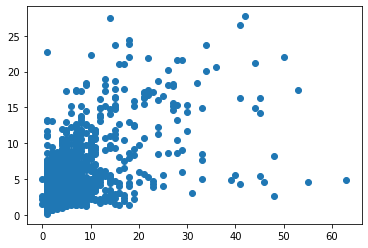

In [82]:
plt.scatter(y_test, predictions)
plt.show()

In [83]:
final = pd.DataFrame({"item_cnt_day":predictions})

In [84]:
pred = df_work.copy()
pred.loc[pred['date_block_num'] >= month_sep, 'item_cnt_day'] = final['item_cnt_day'].values

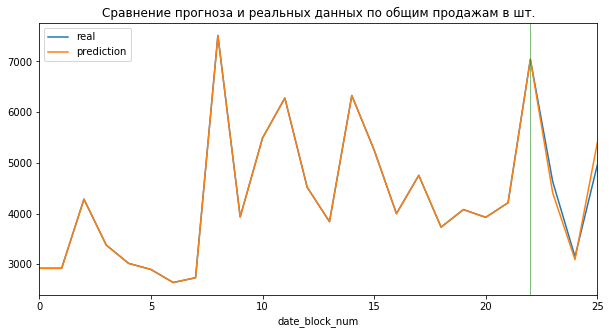

In [85]:
df_work.groupby('date_block_num')['item_cnt_day'].sum().plot(label="real", legend=True, figsize=(10,5))
pred.groupby('date_block_num')['item_cnt_day'].sum().plot(label="prediction", legend=True, figsize=(10,5))
plt.axvline(x = month_sep-1, linewidth=.5 , color='g')
plt.title('Сравнение прогноза и реальных данных по общим продажам в шт.')
plt.show()

In [87]:
pred = pred.merge(items[['item_id','item_category_id']], on='item_id', how='left')

Прогнозируемые продажи по категориям

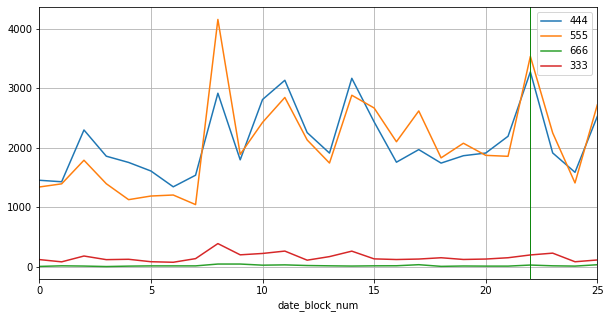

In [89]:
for i in pred['item_category_id'].unique():
    (pred.query('item_category_id == @i')
        .groupby('date_block_num')['item_cnt_day'].sum()
             .plot(legend="True", label=i, grid=True, figsize=(10,5)))
    plt.axvline(x = month_sep-1, linewidth=.5 , color='g')

Использование кросс-валидации для расчета средних метрик качества модели и настройки гиперпараметров (для избежания переобучения), думаю имеет смысл использовать для прогноза на более длительный период - например 6 мес., в таком случае нужно будет получить больше данных - за 3-5 лет. На данном примере, считаю, такой подход может негативно сказаться на качестве метрик и прогноза.

In [90]:
march_model = df.query('date_block_num == 26').drop(['item_id','item_cnt_day'], axis=1)

In [91]:
march_pred = model.predict(march_model)

In [92]:
final_submission.loc[final_submission['date_block_num'] == 26,'item_cnt_day'] = march_pred

Округляем смоделированные значения

In [93]:
final_submission['item_cnt_day'] =  final_submission['item_cnt_day'].round(0)

График с общими продажами в шт.

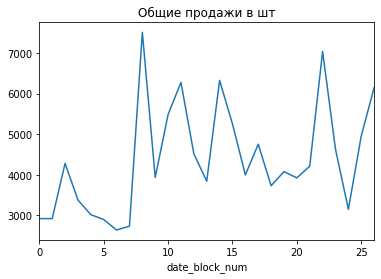

In [94]:
final_submission.groupby('date_block_num')['item_cnt_day'].sum().plot()
plt.title('Общие продажи в шт')
plt.show()

In [95]:
final_submission = (final_submission.query('date_block_num == 26')
                    .groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum()).reset_index()

Сохраняем итоговый результат с прогнозом

In [96]:
final_submission.to_csv('final_submission.csv')